In [1]:
import pandas as pd

In [76]:
import numpy as np


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [3]:
import sys
import os

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import helpers
import data_processing as dp
import lstm
import ee_model

['d:\\Repositories\\PhD\\notebooks\\SoThNoDyML', 'd:\\Anaconda\\envs\\ai-env-torch\\python310.zip', 'd:\\Anaconda\\envs\\ai-env-torch\\DLLs', 'd:\\Anaconda\\envs\\ai-env-torch\\lib', 'd:\\Anaconda\\envs\\ai-env-torch', '', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [189]:
importlib.reload(dp)

<module 'data_processing' from 'D:\\Repositories\\PhD\\src\\classes\\data_processing.py'>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy


In [18]:
torch.cuda.is_available()

True

# LSTM AE Class

In [184]:
class DeepLSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, bottleneck_dim=32, device='cuda', mode = 'AD'):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True)
        self.bottleneck = nn.LSTM(hidden_dim, bottleneck_dim, num_layers=2, batch_first=True)
        self.decoder = nn.LSTM(bottleneck_dim, hidden_dim, num_layers=3, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        self.device = device
        self.to(device)
        self.mode = mode

    def _get_input(self, batch):
        return batch[0] if isinstance(batch, (list, tuple)) else batch
    
    def set_threshold(self, train_loader):
        """
        Compute and store the maximum MAE across the healthy training set.
        """
        self.eval()
        all_mae = []
        with torch.no_grad():
            for batch in train_loader:
                x = self._get_input(batch).to(self.device)
                recon = self.forward(x)
                mae = torch.mean(torch.abs(recon - x), dim=[1, 2])  # [batch_size]
                all_mae.append(mae.cpu())
        self.threshold = torch.cat(all_mae).max().item()
        print(f"Threshold set to max MAE on training data: {self.threshold:.6f}")

    def forward(self, x):
        encoded, _ = self.encoder(x)
        bottleneck_out, _ = self.bottleneck(encoded)
        decoded, _ = self.decoder(bottleneck_out)
        return self.output_layer(decoded)

    def encode(self, x):
        with torch.no_grad():
            encoded, _ = self.encoder(x)
            bottleneck_out, _ = self.bottleneck(encoded)
        return bottleneck_out

    def train_model(self, train_loader, val_loader=None, num_epochs=50, lr=1e-3, 
                    patience=5, min_delta=1e-4):
        self.train()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(self.state_dict())

        history = {
            'train_loss': [],
            'val_loss': []
        }

        for epoch in range(num_epochs):
            total_train_loss = 0
            self.train()
            for batch in train_loader:
                batch = self._get_input(batch).to(self.device)
                output = self.forward(batch)
                loss = criterion(output, batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}", end="")

            # Validation loss
            if val_loader is not None:
                self.eval()
                total_val_loss = 0
                with torch.no_grad():
                    for val_batch in val_loader:
                        val_batch = self._get_input(val_batch).to(self.device)
                        val_output = self.forward(val_batch)
                        val_loss = criterion(val_output, val_batch)
                        total_val_loss += val_loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                history['val_loss'].append(avg_val_loss)
                print(f", Val Loss: {avg_val_loss:.6f}")

                # Early stopping
                if avg_val_loss < best_val_loss - min_delta:
                    best_val_loss = avg_val_loss
                    best_model_wts = copy.deepcopy(self.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print(f"Early stopping triggered at epoch {epoch+1}")
                        break
            else:
                print()
                history['val_loss'].append(None)  # to keep alignment

        self.load_state_dict(best_model_wts)
        if (self.mode is not None) and (self.mode == 'AD'):
            self.set_threshold(train_loader)
        
        return history

    def evaluate_model(self, test_loader):
        self.eval()
        criterion = nn.MSELoss()
        total_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = self._get_input(batch).to(self.device)
                output = self.forward(batch)
                loss = criterion(output, batch)
                total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        print(f"Test Loss: {avg_loss:.6f}")
        return avg_loss

    def extract_features_single_batch(self, batch):
        self.eval()
        batch = self._get_input(batch).to(self.device)
        bottleneck_out = self.encode(batch)
        return bottleneck_out[:, -1, :]  # Last time step as feature vector

    def extract_features_dataloader(self, dataloader):
        self.eval()
        features = []
        with torch.no_grad():
            for batch in dataloader:
                batch = self._get_input(batch).to(self.device)
                bottleneck_out = self.encode(batch)
                features.append(bottleneck_out[:, -1, :])  # Last timestep
        return torch.cat(features, dim=0)
    
    def predict(self, loader, threshold=None, return_scores=False):
        """
        Predict anomalies using MAE. Returns 0 (normal) or 1 (anomaly) per sample.
        """
        self.eval()
        preds = []
        scores = []
        threshold = threshold or getattr(self, 'threshold', None)
        assert threshold is not None, "Threshold must be set or passed."

        with torch.no_grad():
            for batch in loader:
                x = self._get_input(batch).to(self.device)
                recon = self.forward(x)
                mae = torch.mean(torch.abs(recon - x), dim=[1, 2])  # [batch_size]
                score = mae.cpu().numpy()
                pred = (mae > threshold).int().cpu().numpy()
                scores.extend(score)
                preds.extend(pred)

        if return_scores:
            return np.array(preds), np.array(scores)
        return np.array(preds)
    
    def save_model(self, path: str):
        """
        Save model state_dict and architecture parameters to a file.
        """
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'input_dim': self.encoder.input_size,
            'hidden_dim': self.encoder.hidden_size,
            'bottleneck_dim': self.bottleneck.hidden_size,
            'device': self.device
        }
        torch.save(checkpoint, path)
        print(f"Model saved to {path}")

    @classmethod
    def load_model(cls, path: str, device='cpu'):
        """
        Load model from a saved checkpoint and return an instance.
        """
        checkpoint = torch.load(path, map_location=device)
        model = cls(
            input_dim=checkpoint['input_dim'],
            hidden_dim=checkpoint['hidden_dim'],
            bottleneck_dim=checkpoint['bottleneck_dim'],
            device=device
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        print(f"Model loaded from {path}")
        return model

In [6]:
import data_processing as dp

In [7]:
import matplotlib.pyplot as plt

In [8]:
import importlib

# Data Prep

In [13]:
df_1730 = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df_1772 = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1772_case_edu.csv")
df_1797 = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1797_case_edu.csv")

In [10]:
df_1730

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [14]:
df_1730_healthy = df_1730[df_1730['fault'] == 0]
df_1772_healthy = df_1772[df_1772['fault'] == 0]
df_1797_healthy = df_1797[df_1797['fault'] == 0]

In [12]:
df_1730_healthy

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
485638,0.035673,0.125122,0,3,1730,0,12000,0,0
485639,-0.004590,0.124916,0,3,1730,0,12000,0,0
485640,-0.023574,0.109302,0,3,1730,0,12000,0,0
485641,0.005215,0.052185,0,3,1730,0,12000,0,0


In [20]:
df_healthy = pd.concat((df_1730_healthy, df_1772_healthy, df_1797_healthy))

In [23]:
df_healthy

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
243933,-0.059664,0.142791,0,0,1797,0,12000,0,0
243934,-0.063836,0.148955,0,0,1797,0,12000,0,0
243935,-0.034630,0.140531,0,0,1797,0,12000,0,0
243936,0.016689,0.095536,0,0,1797,0,12000,0,0


Text(0.5, 1.0, 'Healthy Vibration Distribution - Drive End')

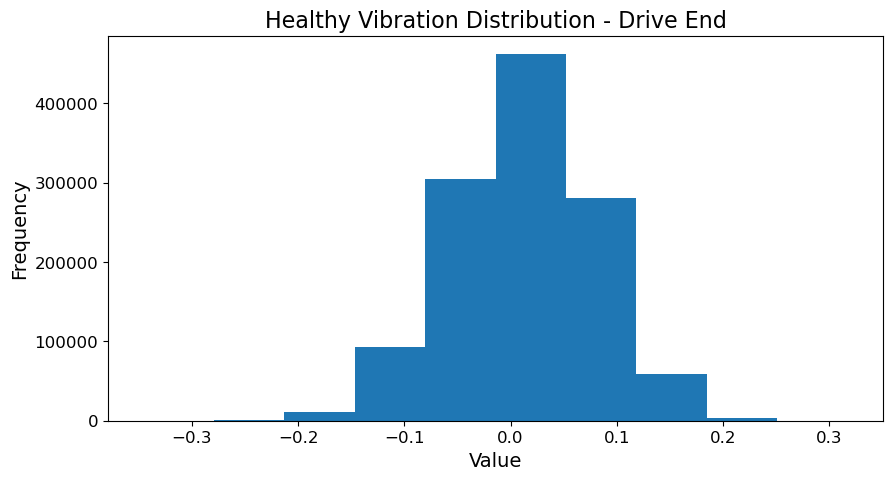

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(df_healthy['DE'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Frequency', fontdict= {'fontsize' : 14})
plt.xlabel('Value', fontdict= {'fontsize' : 14})
plt.title('Healthy Vibration Distribution - Drive End', fontdict={'fontsize' : 16})

Text(0.5, 1.0, 'Healthy Vibration Distribution - Fan End')

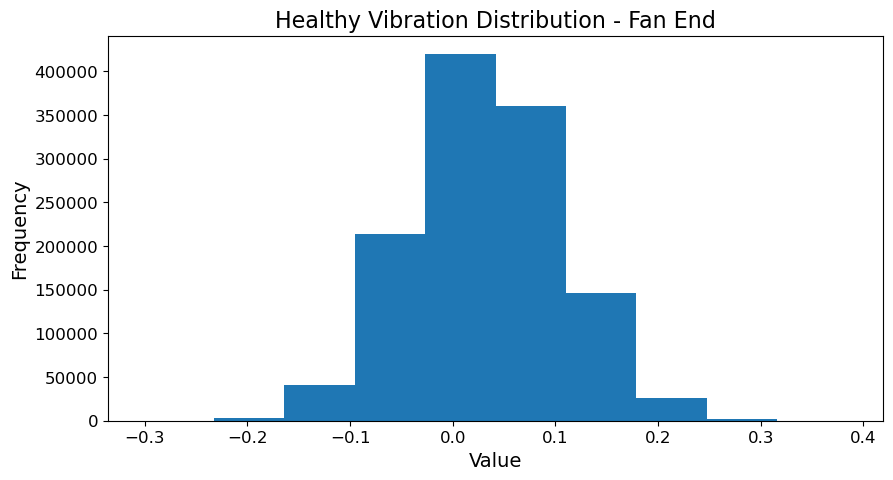

In [28]:
plt.figure(figsize=(10, 5))
plt.hist(df_healthy['FE'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Frequency', fontdict= {'fontsize' : 14})
plt.xlabel('Value', fontdict= {'fontsize' : 14})
plt.title('Healthy Vibration Distribution - Fan End', fontdict={'fontsize' : 16})

In [30]:
from statsmodels.tsa.stattools import adfuller, kpss

def chunked_stationarity_test(series, chunk_size=50000, test='adf'):
    """
    Apply ADF or KPSS test on chunks of a long time series.

    Parameters:
        series (pd.Series or np.array): The full time series (1D).
        chunk_size (int): Number of points per chunk.
        test (str): 'adf' or 'kpss'.

    Returns:
        List of dictionaries with chunk index, p-value, and stationarity decision.
    """
    results = []
    n_chunks = len(series) // chunk_size

    for i in range(n_chunks):
        chunk = series[i * chunk_size: (i + 1) * chunk_size]

        try:
            if test == 'adf':
                stat, pvalue, _, _, crit_vals, _ = adfuller(chunk)
                is_stationary = pvalue < 0.05
            elif test == 'kpss':
                stat, pvalue, _, crit_vals = kpss(chunk, regression='c', nlags='auto')
                is_stationary = pvalue >= 0.05
            else:
                raise ValueError("test must be 'adf' or 'kpss'")

            results.append({
                'chunk': i,
                'p-value': round(pvalue, 6),
                'stationary': is_stationary,
                'critical_values': crit_vals
            })

        except Exception as e:
            results.append({
                'chunk': i,
                'error': str(e),
                'stationary': None,
                'p-value': None
            })

    return results

In [32]:
results_adf_de = chunked_stationarity_test(df_healthy['DE'], test = 'adf')
print("Done ADF DE")
results_kpss_de = chunked_stationarity_test(df_healthy['DE'], test = 'kpss')
print("Done KPSS DE")
results_adf_fe = chunked_stationarity_test(df_healthy['FE'], test = 'adf')
print("Done ADF FE")
results_kpss_fe = chunked_stationarity_test(df_healthy['FE'], test = 'kpss')
print("Done KPSS FE")

Done ADF DE
Done KPSS DE


C:\Users\Hacko Academic\AppData\Local\Temp\ipykernel_12304\3762437980.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, _, crit_vals = kpss(chunk, regression='c', nlags='auto')
C:\Users\Hacko Academic\AppData\Local\Temp\ipykernel_12304\3762437980.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, _, crit_vals = kpss(chunk, regression='c', nlags='auto')
C:\Users\Hacko Academic\AppData\Local\Temp\ipykernel_12304\3762437980.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, _, crit_vals = kpss(chunk, regression='c', nlags='auto')
C:\Users\Hacko Academic\AppData\Local\Temp\ipyker

Done ADF FE
Done KPSS FE


C:\Users\Hacko Academic\AppData\Local\Temp\ipykernel_12304\3762437980.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pvalue, _, crit_vals = kpss(chunk, regression='c', nlags='auto')
C:\Users\Hacko Academic\AppData\Local\Temp\ipykernel_12304\3762437980.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, _, crit_vals = kpss(chunk, regression='c', nlags='auto')
C:\Users\Hacko Academic\AppData\Local\Temp\ipykernel_12304\3762437980.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, _, crit_vals = kpss(chunk, regression='c', nlags='auto')
C:\Users\Hacko Academic\AppData\Local\Temp\ipyker

In [36]:
results_kpss_de

[{'chunk': 0,
  'p-value': 0.014778,
  'stationary': False,
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 {'chunk': 1,
  'p-value': 0.1,
  'stationary': True,
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 {'chunk': 2,
  'p-value': 0.1,
  'stationary': True,
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 {'chunk': 3,
  'p-value': 0.1,
  'stationary': True,
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 {'chunk': 4,
  'p-value': 0.070685,
  'stationary': True,
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 {'chunk': 5,
  'p-value': 0.069958,
  'stationary': True,
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 {'chunk': 6,
  'p-value': 0.1,
  'stationary': True,
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 {'chunk': 7,
  'p-value': 0.1,
  'stationary': True,

In [134]:
data_process = dp.DataProcesser()

In [185]:
train_loader_de, val_loader_de, test_loader_de, scaler_de = data_process.prepare_autoencoder_data(df_healthy['DE'], window_size=10, stride=1, train_ratio=0.7, val_ratio=0.15, batch_size=32, test=False, scaler_method = 'standard')
train_loader_fe, val_loader_fe, test_loader_fe, scaler_fe = data_process.prepare_autoencoder_data(df_healthy['FE'], window_size=10, stride=1, train_ratio=0.7, val_ratio=0.15, batch_size=32, test=False, scaler_method = 'standard')

In [186]:
test_loader_de

# DE Training

In [132]:
lstm_ae_de = DeepLSTMAutoencoder()
lstm_ae_fe = DeepLSTMAutoencoder()

In [133]:
lstm_ae_de.device

'cuda'

In [136]:
history = lstm_ae_de.train_model(train_loader_de, val_loader=val_loader_de, num_epochs=100, lr=1e-3, patience=5, min_delta=1e-4)

Epoch 1/100 - Train Loss: 0.004092, Val Loss: 0.000100
Epoch 2/100 - Train Loss: 0.000074, Val Loss: 0.000021
Epoch 3/100 - Train Loss: 0.000048, Val Loss: 0.000005
Epoch 4/100 - Train Loss: 0.000038, Val Loss: 0.000108
Epoch 5/100 - Train Loss: 0.000033, Val Loss: 0.000009
Epoch 6/100 - Train Loss: 0.000027, Val Loss: 0.000022
Early stopping triggered at epoch 6


In [137]:
lstm_ae_de.evaluate_model(test_loader_de)

Test Loss: 0.000108


0.00010758695618350841

In [138]:
from sklearn.metrics import r2_score

def calculate_r2_score(model, test_loader):
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, (list, tuple)):
                batch = batch[0]
            batch = batch.to(model.device)
            output = model(batch)

            all_true.append(batch.cpu())
            all_pred.append(output.cpu())

    y_true = torch.cat(all_true, dim=0).numpy()
    y_pred = torch.cat(all_pred, dim=0).numpy()

    # Flatten if necessary
    y_true_flat = y_true.reshape(len(y_true), -1)
    y_pred_flat = y_pred.reshape(len(y_pred), -1)

    r2 = r2_score(y_true_flat, y_pred_flat)
    print(f"R² Score on Test Set: {r2:.6f}")
    return r2

print("R2:", calculate_r2_score(lstm_ae_de, test_loader_de))

R² Score on Test Set: 0.999910
R2: 0.9999100231371403


Text(0.5, 1.0, 'LSTM AutoEncoder Training Drive End')

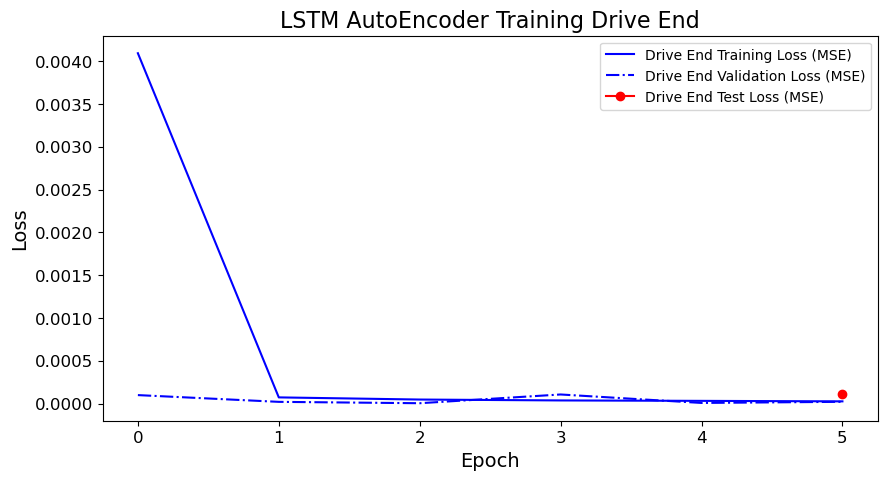

In [139]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], '-', color = 'b', label = 'Drive End Training Loss (MSE)')
plt.plot(history['val_loss'], '-.', color = 'b', label = 'Drive End Validation Loss (MSE)')
plt.plot(5, 0.000108, marker = 'o', color = 'red', label = 'Drive End Test Loss (MSE)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Loss', fontdict= {'fontsize' : 14})
plt.xlabel('Epoch', fontdict= {'fontsize' : 14})
plt.legend()
plt.title('LSTM AutoEncoder Training Drive End', fontdict={'fontsize' : 16})

In [140]:
lstm_ae_de.save_model(r'D:\Repositories\PhD\models\LSTM_AE_DE.pth')

Model saved to D:\Repositories\PhD\models\LSTM_AE_DE.pth


# FE Training

In [157]:
history_fe = lstm_ae_fe.train_model(train_loader_fe, val_loader=val_loader_fe, num_epochs=100, lr=1e-3, patience=5, min_delta=1e-4)

Epoch 1/100 - Train Loss: 0.004329, Val Loss: 0.000001
Epoch 2/100 - Train Loss: 0.000073, Val Loss: 0.000016
Epoch 3/100 - Train Loss: 0.000051, Val Loss: 0.000000
Epoch 4/100 - Train Loss: 0.000040, Val Loss: 0.000025
Epoch 5/100 - Train Loss: 0.000034, Val Loss: 0.000003
Epoch 6/100 - Train Loss: 0.000031, Val Loss: 0.000080
Early stopping triggered at epoch 6


In [158]:
lstm_ae_fe.evaluate_model(test_loader_fe)

Test Loss: 0.000002


2.1809272827544216e-06

In [159]:
print("R2:", calculate_r2_score(lstm_ae_fe, test_loader_fe))

R² Score on Test Set: 0.999998
R2: 0.999998131530522


Text(0.5, 1.0, 'LSTM AutoEncoder Training Fan End')

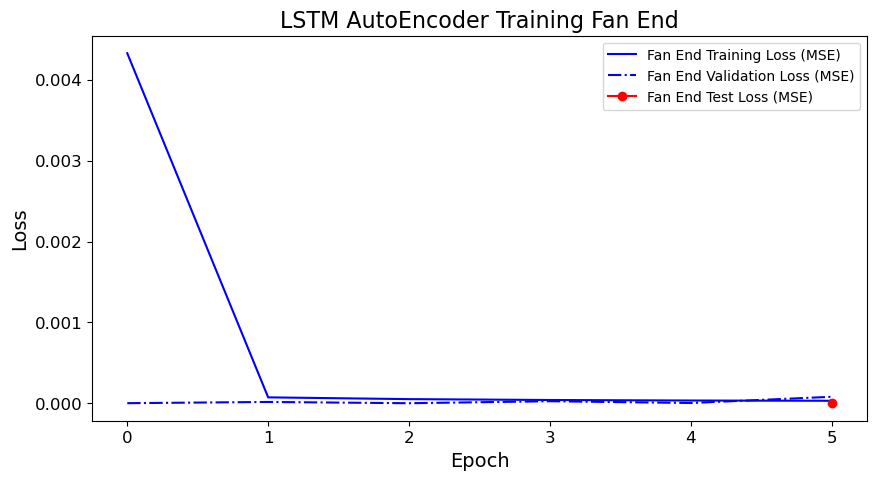

In [160]:
plt.figure(figsize=(10, 5))
plt.plot(history_fe['train_loss'], '-', color = 'b', label = 'Fan End Training Loss (MSE)')
plt.plot(history_fe['val_loss'], '-.', color = 'b', label = 'Fan End Validation Loss (MSE)')
plt.plot(5, 0.000006, marker = 'o', color = 'red', label = 'Fan End Test Loss (MSE)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Loss', fontdict= {'fontsize' : 14})
plt.xlabel('Epoch', fontdict= {'fontsize' : 14})
plt.legend()
plt.title('LSTM AutoEncoder Training Fan End', fontdict={'fontsize' : 16})

In [161]:
lstm_ae_fe.save_model(r'D:\Repositories\PhD\models\LSTM_AE_FE.pth')

Model saved to D:\Repositories\PhD\models\LSTM_AE_FE.pth


# Both Ends LSTM AE Modeling

In [192]:
data_process = dp.DataProcesser()

In [193]:
train_loader_both, val_loader_both, test_loader_both, scaler_both = data_process.prepare_autoencoder_data(df_healthy[['DE','FE']], window_size=10, stride=1, train_ratio=0.7, val_ratio=0.15, batch_size=32, test=False, scaler_method = 'standard')

(1213484, 2)


In [194]:
for batch in train_loader_both:
    if isinstance(batch, (list, tuple)):
        x, y = batch
    else:
        x = batch
        y = None
    print("X shape:", x.shape)
    if y is not None:
        print("Y shape:", y.shape)
    break

X shape: torch.Size([32, 10, 2])
Y shape: torch.Size([32, 10, 2])


In [197]:
lstm_ae_both = DeepLSTMAutoencoder(input_dim=2)

In [198]:
history_both = lstm_ae_both.train_model(train_loader_both, val_loader=val_loader_both, num_epochs=100, lr=1e-3, patience=5, min_delta=1e-4)

Epoch 1/100 - Train Loss: 0.011044, Val Loss: 0.000506
Epoch 2/100 - Train Loss: 0.000090, Val Loss: 0.000106
Epoch 3/100 - Train Loss: 0.000063, Val Loss: 0.000014
Epoch 4/100 - Train Loss: 0.000054, Val Loss: 0.000016
Epoch 5/100 - Train Loss: 0.000042, Val Loss: 0.000326
Epoch 6/100 - Train Loss: 0.000037, Val Loss: 0.000005
Epoch 7/100 - Train Loss: 0.000033, Val Loss: 0.000004
Epoch 8/100 - Train Loss: 0.000031, Val Loss: 0.000010
Epoch 9/100 - Train Loss: 0.000029, Val Loss: 0.000006
Epoch 10/100 - Train Loss: 0.000025, Val Loss: 0.000029
Epoch 11/100 - Train Loss: 0.000025, Val Loss: 0.000007
Early stopping triggered at epoch 11
Threshold set to max MAE on training data: 0.018783


In [199]:
lstm_ae_both.evaluate_model(test_loader_both)

Test Loss: 0.000007


7.345816524966292e-06

In [200]:
print("R2:", calculate_r2_score(lstm_ae_both, test_loader_both))

R² Score on Test Set: 0.999994
R2: 0.9999937816610631


Text(0.5, 1.0, 'LSTM AutoEncoder Training Both Ends')

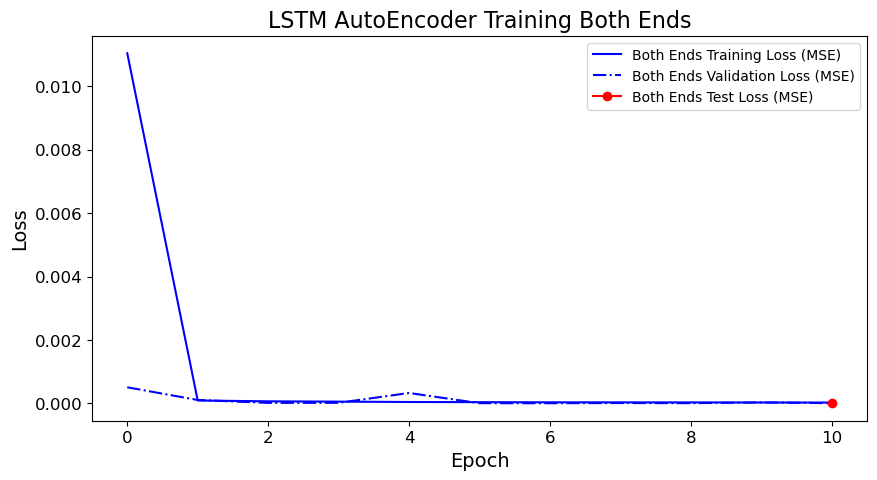

In [205]:
plt.figure(figsize=(10, 5))
plt.plot(history_both['train_loss'], '-', color = 'b', label = 'Both Ends Training Loss (MSE)')
plt.plot(history_both['val_loss'], '-.', color = 'b', label = 'Both Ends Validation Loss (MSE)')
plt.plot(10, 0.000010, marker = 'o', color = 'red', label = 'Both Ends Test Loss (MSE)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Loss', fontdict= {'fontsize' : 14})
plt.xlabel('Epoch', fontdict= {'fontsize' : 14})
plt.legend()
plt.title('LSTM AutoEncoder Training Both Ends', fontdict={'fontsize' : 16})

In [206]:
lstm_ae_fe.save_model(r'D:\Repositories\PhD\models\LSTM_AE_Both.pth')

Model saved to D:\Repositories\PhD\models\LSTM_AE_Both.pth


# Classification with LSTM AE Extracted features

## Extract Features for both DE and FE

In [75]:
overall_df = pd.concat((df_1730, df_1772, df_1797))
overall_df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3405142,-0.320642,-0.199291,21,0,1797,2,48000,3,1
3405143,0.047982,-0.487955,21,0,1797,2,48000,3,1
3405144,0.306873,-0.015409,21,0,1797,2,48000,3,1
3405145,-0.050902,0.155529,21,0,1797,2,48000,3,1


In [86]:
def fast_extract_windows(df, motor_end_name, window_size=10, label_column='fault'):
    values = df[motor_end_name].values  # shape: (N, input_dim)
    labels = df[label_column].values

    # shape: (N - window_size + 1, window_size, input_dim)
    X = np.lib.stride_tricks.sliding_window_view(values, window_shape=window_size, axis=0)
    
    # pick label from the last step of each window
    y = labels[window_size - 1:]

    return X, y

In [141]:
from sklearn.utils import shuffle

X_de_1730, y_de_1730 = fast_extract_windows(df_1730, 'DE')
print("Window Extraction done!")
X_de_1730_shuffled, y_de_1730_shuffled = shuffle(X_de_1730, y_de_1730, random_state=42)

Window Extraction done!


In [142]:
X_de_1730.shape

(3528361, 10)

In [143]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(torch.tensor(X_de_1730_shuffled, dtype=torch.float32).unsqueeze(-1),
                        torch.tensor(y_de_1730_shuffled, dtype=torch.long).unsqueeze(-1))

loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [144]:
for batch in loader:
    if isinstance(batch, (list, tuple)):
        x, y = batch
    else:
        x = batch
        y = None
    print("X shape:", x.shape)
    if y is not None:
        print("Y shape:", y.shape)
    break

X shape: torch.Size([32, 10, 1])
Y shape: torch.Size([32, 1])


In [145]:
extracted_features = lstm_ae_de.extract_features_dataloader(loader)
extracted_features

tensor([[ 0.0332, -0.0222,  0.0190,  ..., -0.0711,  0.0128,  0.0812],
        [ 0.0011, -0.0688, -0.0196,  ..., -0.0339, -0.0336,  0.0519],
        [-0.0008, -0.0718, -0.0193,  ..., -0.0320, -0.0360,  0.0483],
        ...,
        [ 0.0066, -0.0622, -0.0165,  ..., -0.0403, -0.0252,  0.0597],
        [ 0.0286, -0.0274,  0.0194,  ..., -0.0664,  0.0073,  0.0721],
        [ 0.0021, -0.0683, -0.0207,  ..., -0.0356, -0.0314,  0.0554]],
       device='cuda:0')

In [146]:
X_de_1730_shuffled = extracted_features.cpu().numpy()

In [147]:
X_de_1730_shuffled.shape

(3528361, 32)

In [148]:
y_de_1730_shuffled.shape

(3528361,)

In [149]:
from xgboost import XGBClassifier

In [150]:
xgbc_1730_de = XGBClassifier()

In [110]:
from sklearn.model_selection import train_test_split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_de_1730_shuffled, y_de_1730_shuffled, test_size=0.2, random_state=42, shuffle = True)

In [113]:
from sklearn.metrics import roc_curve

In [152]:
xgbc_1730_de.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [153]:
y_train_pred_de_1730 = xgbc_1730_de.predict_proba(X_train)[:, 1]
y_test_pred_de_1730 = xgbc_1730_de.predict_proba(X_test)[:, 1]

In [154]:
fpr_train_de_1730, tpr_train_de_1730, _ = roc_curve(y_train, y_train_pred_de_1730)
fpr_test_de_1730, tpr_test_de_1730, thr_de_1730 = roc_curve(y_test, y_test_pred_de_1730)

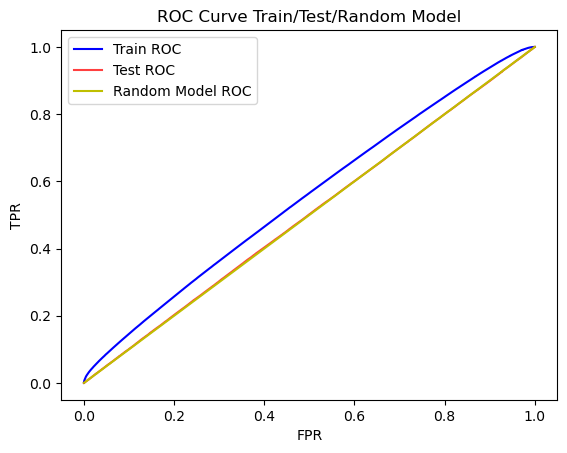

In [155]:
helpers.plot_roc((fpr_train_de_1730, tpr_train_de_1730), (fpr_test_de_1730, tpr_test_de_1730), roc_bm = None)

# Both Channels

In [210]:
def prepare_feature_extraction_data(df, window_size=10, stride=1, batch_size=32, scaler_method='standard'):
    """
    Prepares multivariate time series for feature extraction using a trained LSTM autoencoder.

    Args:
        df (pd.DataFrame): Input time series with shape (N, n_features).
        window_size (int): Length of each sequence window.
        stride (int): Step size for sliding window.
        batch_size (int): Batch size for the DataLoader.
        scaler_method (str): Scaling method ('standard' or 'minmax').

    Returns:
        DataLoader: Dataloader with (X, X) for LSTM autoencoder input.
        Scaler: Fitted scaler (can be reused to inverse transform).
    """
    from sklearn.preprocessing import StandardScaler, minmax_scale
    import torch
    from torch.utils.data import TensorDataset, DataLoader

    # Scale features
    if scaler_method == 'standard':
        scaler = StandardScaler()
        if len(df.shape) == 2:
            scaled = scaler.fit_transform(df.values)  # shape: (N, n_features)
        else:
            scaled = scaler.fit_transform(df.values.reshape(-1, 1))
    elif scaler_method == 'minmax':
        scaler = None
        scaled = minmax_scale(df.values)  # shape: (N, n_features)
    else:
        raise NotImplementedError(f"{scaler_method} is not supported")

    series_tensor = torch.tensor(scaled, dtype=torch.float32)  # shape: (N, n_features)

    # Extract windows
    X = []
    for i in range(0, len(series_tensor) - window_size + 1, stride):
        window = series_tensor[i:i + window_size]  # shape: (window_size, n_features)
        X.append(window)

    X_tensor = torch.stack(X)  # shape: (num_windows, window_size, n_features)
    Y_tensor = X_tensor.clone()  # for autoencoder, Y == X

    dataset = TensorDataset(X_tensor, Y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return loader, scaler

In [ ]:
def fast_extract_windows(df, motor_end_name, window_size=10, label_column='fault'):
    values = df[motor_end_name].values  # shape: (N, input_dim)
    labels = df[label_column].values

    # shape: (N - window_size + 1, window_size, input_dim)
    X = np.lib.stride_tricks.sliding_window_view(values, window_shape=window_size, axis=0)
    
    # pick label from the last step of each window
    y = labels[window_size - 1:]

    return X, y

In [245]:
df_1730

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [260]:
df_1730[((df_1730['fault_diameter'] == 7) | (df_1730['fault'] == 0)) & (df_1730['samples_per_second'] == 12000)]

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
1097099,-1.011565,-0.039447,7,3,1730,1,12000,1,1
1097100,-0.527914,0.126971,7,3,1730,1,12000,1,1
1097101,0.886896,-0.034722,7,3,1730,1,12000,1,1
1097102,0.845881,0.112795,7,3,1730,1,12000,1,1


In [261]:
X_both_1730, _ = prepare_feature_extraction_data(df_1730[((df_1730['fault_diameter'] == 7) | (df_1730['fault'] == 0)) & (df_1730['samples_per_second'] == 12000)][['DE', 'FE']])

In [262]:
from torch.utils.data import TensorDataset, DataLoader

for batch in X_both_1730:
    if isinstance(batch, (list, tuple)):
        x, y = batch
    else:
        x = batch
        y = None
    print("X shape:", x.shape)
    if y is not None:
        print("Y shape:", y.shape)
    break

extracted_features = lstm_ae_both.extract_features_dataloader(X_both_1730)
extracted_features

X shape: torch.Size([32, 10, 2])
Y shape: torch.Size([32, 10, 2])


tensor([[ 1.9599e-05, -8.7225e-03, -4.2448e-02,  ...,  2.9104e-04,
         -2.7810e-02,  7.1006e-02],
        [ 1.1166e-05, -3.1570e-03, -4.7118e-02,  ...,  2.3451e-04,
         -2.0668e-02,  8.1337e-02],
        [ 3.5446e-05,  6.6900e-04, -4.6088e-02,  ...,  1.8360e-04,
         -6.3835e-03,  8.1023e-02],
        ...,
        [-4.5804e-04, -9.4610e-02, -1.4817e-01,  ...,  1.8770e-02,
         -1.1809e-01,  1.6709e-01],
        [-5.4926e-04, -6.9057e-02, -2.6207e-01,  ...,  6.3092e-03,
         -1.8375e-01,  3.3310e-01],
        [ 7.0726e-03,  6.1730e-02,  4.8367e-02,  ..., -3.7738e-03,
          5.5243e-02, -1.1765e-01]], device='cuda:0')

In [263]:
extracted_features

tensor([[ 1.9599e-05, -8.7225e-03, -4.2448e-02,  ...,  2.9104e-04,
         -2.7810e-02,  7.1006e-02],
        [ 1.1166e-05, -3.1570e-03, -4.7118e-02,  ...,  2.3451e-04,
         -2.0668e-02,  8.1337e-02],
        [ 3.5446e-05,  6.6900e-04, -4.6088e-02,  ...,  1.8360e-04,
         -6.3835e-03,  8.1023e-02],
        ...,
        [-4.5804e-04, -9.4610e-02, -1.4817e-01,  ...,  1.8770e-02,
         -1.1809e-01,  1.6709e-01],
        [-5.4926e-04, -6.9057e-02, -2.6207e-01,  ...,  6.3092e-03,
         -1.8375e-01,  3.3310e-01],
        [ 7.0726e-03,  6.1730e-02,  4.8367e-02,  ..., -3.7738e-03,
          5.5243e-02, -1.1765e-01]], device='cuda:0')

In [264]:
X = extracted_features.to('cpu').numpy()

In [265]:
df_class = pd.DataFrame(X)

In [266]:
df_class

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.000020,-0.008722,-0.042448,-0.010561,-0.012203,-0.000120,-0.004766,0.002315,-0.009108,-0.007654,...,-0.005902,-0.052598,0.015810,0.023601,0.022911,0.059694,0.019001,0.000291,-0.027810,0.071006
1,0.000011,-0.003157,-0.047118,-0.010245,-0.011168,-0.000103,0.001803,0.002684,-0.003663,-0.008150,...,-0.003613,-0.072600,0.008135,0.018991,0.036164,0.063888,0.021387,0.000235,-0.020668,0.081337
2,0.000035,0.000669,-0.046088,-0.008220,-0.008426,-0.000101,0.008160,0.002600,0.005071,-0.007364,...,-0.000235,-0.080526,-0.000415,0.006905,0.050620,0.061580,0.021453,0.000184,-0.006384,0.081023
3,0.000055,-0.003954,-0.042822,-0.008038,-0.008379,-0.000125,0.005305,0.002096,0.003260,-0.006616,...,-0.001440,-0.068538,0.003018,0.003997,0.050347,0.058334,0.019622,0.000261,-0.004793,0.072787
4,0.000058,-0.010892,-0.041239,-0.009544,-0.010899,-0.000147,-0.002652,0.001641,-0.005671,-0.006657,...,-0.005415,-0.052231,0.013063,0.012885,0.035189,0.057964,0.017255,0.000373,-0.016609,0.067040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097090,0.008127,0.067588,0.128404,0.089794,0.151076,0.000977,0.029054,-0.004859,0.091680,0.071278,...,0.095119,0.237939,-0.044549,-0.153449,0.023784,-0.146364,-0.405097,-0.002524,0.159688,-0.224630
1097091,0.000012,0.048045,0.069849,0.003690,0.048787,-0.000204,0.048751,0.003296,0.056867,0.002558,...,0.042245,0.049470,-0.073442,-0.148082,0.104811,-0.068740,0.001162,-0.000356,0.164922,-0.051259
1097092,-0.000458,-0.094610,-0.148166,-0.073790,-0.075353,-0.002008,-0.094775,-0.138986,-0.111753,-0.034569,...,-0.125451,-0.136881,0.069059,0.127674,-0.246142,0.180239,0.034306,0.018770,-0.118089,0.167089
1097093,-0.000549,-0.069057,-0.262069,-0.057784,-0.057607,0.000592,-0.068486,-0.039414,-0.143499,-0.029208,...,-0.155361,-0.372697,0.053301,0.244092,-0.108029,0.376375,0.022145,0.006309,-0.183752,0.333102


In [267]:
window_size = 10
stride = 1
label_column = 'label'

def get_label(df, window_size = 10, stride = 1, label_column = 'fault'):

    # Extract the labels from the end of each window
    labels = []
    for i in range(0, len(df) - window_size + 1, stride):
        label = df.iloc[i + window_size - 1][label_column]
        labels.append(label)

    # Now `labels` is aligned with the extracted windows
    return np.array(labels)

df_class['fault'] = get_label(df_1730[((df_1730['fault_diameter'] == 7) | (df_1730['fault'] == 0)) & (df_1730['samples_per_second'] == 12000)])
df_class

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,fault
0,0.000020,-0.008722,-0.042448,-0.010561,-0.012203,-0.000120,-0.004766,0.002315,-0.009108,-0.007654,...,-0.052598,0.015810,0.023601,0.022911,0.059694,0.019001,0.000291,-0.027810,0.071006,0.0
1,0.000011,-0.003157,-0.047118,-0.010245,-0.011168,-0.000103,0.001803,0.002684,-0.003663,-0.008150,...,-0.072600,0.008135,0.018991,0.036164,0.063888,0.021387,0.000235,-0.020668,0.081337,0.0
2,0.000035,0.000669,-0.046088,-0.008220,-0.008426,-0.000101,0.008160,0.002600,0.005071,-0.007364,...,-0.080526,-0.000415,0.006905,0.050620,0.061580,0.021453,0.000184,-0.006384,0.081023,0.0
3,0.000055,-0.003954,-0.042822,-0.008038,-0.008379,-0.000125,0.005305,0.002096,0.003260,-0.006616,...,-0.068538,0.003018,0.003997,0.050347,0.058334,0.019622,0.000261,-0.004793,0.072787,0.0
4,0.000058,-0.010892,-0.041239,-0.009544,-0.010899,-0.000147,-0.002652,0.001641,-0.005671,-0.006657,...,-0.052231,0.013063,0.012885,0.035189,0.057964,0.017255,0.000373,-0.016609,0.067040,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097090,0.008127,0.067588,0.128404,0.089794,0.151076,0.000977,0.029054,-0.004859,0.091680,0.071278,...,0.237939,-0.044549,-0.153449,0.023784,-0.146364,-0.405097,-0.002524,0.159688,-0.224630,1.0
1097091,0.000012,0.048045,0.069849,0.003690,0.048787,-0.000204,0.048751,0.003296,0.056867,0.002558,...,0.049470,-0.073442,-0.148082,0.104811,-0.068740,0.001162,-0.000356,0.164922,-0.051259,1.0
1097092,-0.000458,-0.094610,-0.148166,-0.073790,-0.075353,-0.002008,-0.094775,-0.138986,-0.111753,-0.034569,...,-0.136881,0.069059,0.127674,-0.246142,0.180239,0.034306,0.018770,-0.118089,0.167089,1.0
1097093,-0.000549,-0.069057,-0.262069,-0.057784,-0.057607,0.000592,-0.068486,-0.039414,-0.143499,-0.029208,...,-0.372697,0.053301,0.244092,-0.108029,0.376375,0.022145,0.006309,-0.183752,0.333102,1.0


In [268]:
df_class = df_class.sample(frac = 1).dropna()

In [269]:
df_class

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,fault
836124,0.000230,-0.027400,-0.111228,0.007741,0.006407,-0.000057,0.011461,-0.001729,0.011897,0.001559,...,-0.146166,-0.017225,0.000215,0.080083,0.103105,-0.012492,0.000788,0.035673,0.082023,1.0
393269,0.000024,-0.001458,-0.016192,-0.008331,-0.007798,-0.000154,-0.001297,0.003047,-0.003310,-0.005759,...,-0.005866,0.016082,-0.004099,0.029526,0.028036,0.013659,0.000123,-0.009920,0.038538,0.0
945212,-0.000132,0.009378,-0.081035,-0.022692,-0.014499,-0.000073,0.016203,0.004153,-0.011252,-0.015185,...,-0.155444,-0.006180,0.014631,0.056266,0.088717,0.017147,0.000522,-0.017324,0.140550,1.0
896003,0.000170,0.011207,0.031203,0.003713,0.011101,-0.000164,0.006020,0.003658,0.020932,0.002908,...,0.077980,0.007497,-0.053780,0.046050,-0.024808,-0.016990,-0.000352,0.035013,-0.031255,1.0
737251,-0.000105,0.027161,0.011830,-0.000766,0.011290,-0.000058,0.017648,0.004698,0.027265,-0.003964,...,0.003216,-0.021321,-0.055110,0.055758,-0.011438,0.013844,-0.000592,0.045069,0.014893,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312268,0.000052,-0.009158,-0.025694,-0.008826,-0.009297,-0.000161,-0.004436,0.002098,-0.005140,-0.005840,...,-0.020461,0.016430,0.003322,0.029897,0.040959,0.013691,0.000258,-0.013317,0.047082,0.0
1044205,-0.000087,-0.024050,-0.067377,-0.017697,-0.024792,-0.000068,-0.025644,0.000024,-0.037764,-0.011452,...,-0.079144,0.030650,0.067340,-0.029302,0.098033,0.019728,0.000591,-0.068961,0.104272,1.0
260127,-0.000038,-0.012013,-0.033167,-0.013644,-0.016209,-0.000139,-0.014527,0.002521,-0.022138,-0.008408,...,-0.018957,0.030015,0.032165,-0.010024,0.048356,0.015601,0.000356,-0.043786,0.058501,0.0
513155,-0.000074,-0.006209,-0.009307,-0.012183,-0.007577,-0.000216,-0.012259,0.002847,-0.011100,-0.005724,...,0.021964,0.023039,0.003157,0.003412,0.018028,0.009683,0.000120,-0.017418,0.026036,1.0


In [270]:
X = df_class.drop(['fault'], axis = 1)
y = df_class['fault']

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle = True)

In [272]:
xgbc_1730_both = XGBClassifier()

In [273]:
xgbc_1730_both.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [274]:
y_train_pred = xgbc_1730_both.predict_proba(X_train)[:, 1]
y_test_pred = xgbc_1730_both.predict_proba(X_test)[:, 1]

In [275]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, thr = roc_curve(y_test, y_test_pred)

In [276]:
y_test.value_counts()

fault
1.0    152603
0.0    121671
Name: count, dtype: int64

Text(0.5, 1.0, 'LSTM AutoEncoder Extracted Features, XGBoost Classifier')

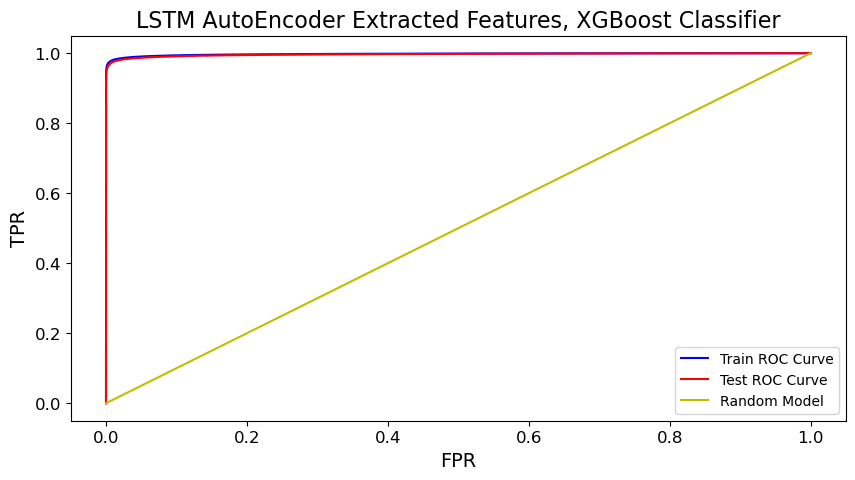

In [292]:
plt.figure(figsize=(10, 5))
plt.plot(fpr_train, tpr_train, '-', color = 'b', label = 'Train ROC Curve')
plt.plot(fpr_test, tpr_test, '-', color = 'r', label = 'Test ROC Curve')
plt.plot(fpr_train, fpr_train, '-', color = 'y', label = 'Random Model')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('TPR', fontdict= {'fontsize' : 14})
plt.xlabel('FPR', fontdict= {'fontsize' : 14})
plt.legend()
plt.title('LSTM AutoEncoder Extracted Features, XGBoost Classifier', fontdict={'fontsize' : 16})

In [287]:
np.argmax(tpr_test - fpr_test)

6977

In [288]:
thr[6977]

0.43921295

In [282]:
best_thr = helpers.get_best_thr(fpr_test[1:], tpr_test[1:], thr[1:])

In [289]:
helpers.print_scores(y_test, np.where(y_test_pred >= 0.43921295, 1, 0))

F1: 0.983
Accuracy: 0.981
Precision: 0.994
ROC AUC: 0.983
Recall: 0.973


In [ ]:
df_class.to_csv(r'D:\Repositories\PhD\parsed_data\EE_data\extracted_features_LSTMAE.csv', index = False)

In [295]:
prediction, scores = lstm_ae_both.predict(X_both_1730, return_scores = True)

In [300]:
fpr_ad, tpr_ad, thr = roc_curve(get_label(df_1730[((df_1730['fault_diameter'] == 7) | (df_1730['fault'] == 0)) & (df_1730['samples_per_second'] == 12000)]), scores)

Text(0.5, 1.0, 'LSTM AutoEncoder Extracted Features, XGBoost Classifier')

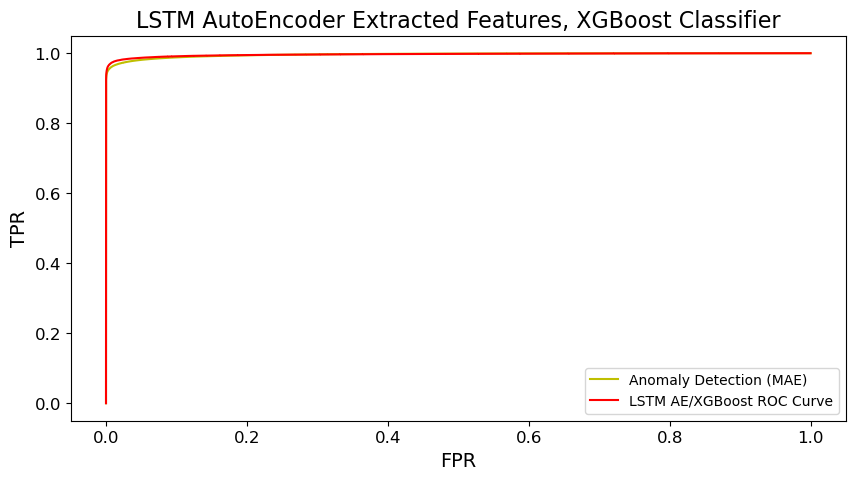

In [302]:
plt.figure(figsize=(10, 5))
plt.plot(fpr_ad, tpr_ad, '-', color = 'y', label = 'Anomaly Detection (MAE)')
plt.plot(fpr_test, tpr_test, '-', color = 'r', label = 'LSTM AE/XGBoost ROC Curve')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('TPR', fontdict= {'fontsize' : 14})
plt.xlabel('FPR', fontdict= {'fontsize' : 14})
plt.legend()
plt.title('LSTM AutoEncoder Extracted Features, XGBoost Classifier', fontdict={'fontsize' : 16})

In [303]:
thr[np.argmax(tpr_ad - fpr_ad)]

0.001317573

In [304]:
helpers.print_scores(get_label(df_1730[((df_1730['fault_diameter'] == 7) | (df_1730['fault'] == 0)) & (df_1730['samples_per_second'] == 12000)]), np.where(scores >= thr[np.argmax(tpr_ad - fpr_ad)], 1, 0))

F1: 0.978
Accuracy: 0.975
Precision: 0.992
ROC AUC: 0.977
Recall: 0.964
